In [2]:
import plyvel
import pandas as pd
import subprocess
import re
import ast
import numpy as np
import matplotlib.pyplot as plt

In [22]:
plt.rcParams.update({'font.size': 22})
#plt.rcParams.update({'size': (10,10)})


# Checking Progress of FAH Project

This notebook analyzes the database of a Folding@Home Workserver. With this you can check for the progress of projects. 
The database is a levelDB database so you must install levelDB on the computer where you run this notebook for the plyvel library to work.

## Download the database and project.xml

Please choose the path to the database in the server as if you were to use rsync (sergio@my_workserver:/my/path/to/worklevel.db) and the project number.

In [3]:
project_number = 16465
rsync_path = "lilac:/home/singhs15/scratch/work-server-db/pllwskifah2/work.leveldb"
project_path = (
    f"lilac:/home/singhs15/scratch/work-server-db/pllwskifah2/{project_number}-project.xml"
)
# rsync_path = "/home/sergio/bin/"

In [4]:
print(f"rsync -uiha --del {rsync_path} work.level.db/")

rsync -uiha --del lilac:/home/singhs15/scratch/work-server-db/pllwskifah2/work.leveldb work.level.db/


## Process Database

In [5]:
output = subprocess.run("rm -rf work.level.db/", shell=True)
output = subprocess.run(
    f"scp -r {rsync_path} ./work.level.db/", capture_output=True, shell=True
)
print("###############")
print("Return code scp work.level.db:", output.returncode)
print("###############")
output = subprocess.run(
    f"scp -r {project_path} work.level.db/project.xml", capture_output=True, shell=True
)
print("Return code scp project.xml:", output.returncode)
print("###############")
print("Output:", output.stdout.decode("utf-8"))

###############
Return code scp work.level.db: 0
###############
Return code scp project.xml: 0
###############
Output: 


In [6]:
db = plyvel.DB("/Users/sukrit/work/scripts/choderalab/folding_at_home_scripts/work.level.db", create_if_missing=False)

In [7]:
l = []
for key, value in db:
    if re.search(f"P{project_number}", str(key)):
        entry = db.get(key)
        entry = ast.literal_eval(entry.decode("UTF-8"))
        l.append(entry)
df = pd.DataFrame()
df = df.append(l, ignore_index=True, sort=False)
df.head()

,server,state,project,core,run,clone,gen,retries,assigns,progress,assigned
0,2359493842,READY,16465,34,0,0,100,0,147,0.400,NaN
1,2359493842,READY,16465,34,0,1,82,1,124,0.328,NaN
2,2359493842,READY,16465,34,0,10,86,0,128,0.344,NaN
3,2359493842,READY,16465,34,0,100,95,1,138,0.380,NaN
4,2359493842,FAILED,16465,34,0,1000,99,4,147,0.396,NaN


In [8]:
file = open("work.level.db/project.xml", "r")
for line in file:
    if re.search("runs", line):
        myRegex = re.compile(r"[0-9]+")
        n_runs = int(myRegex.findall(line)[0])
    if re.search("clones", line):
        myRegex = re.compile(r"[0-9]+")
        n_clones = int(myRegex.findall(line)[0])
    if re.search("gens", line):
        myRegex = re.compile(r"[0-9]+")
        n_gens = int(myRegex.findall(line)[0])
print(f"P{project_number} has {n_runs} runs with {n_clones} clones and {n_gens} gens.")

P16465 has 1 runs with 4000 clones and 250 gens.


## Progress of project

In [36]:
finished_clones = df[np.logical_and(df.gen == n_gens, df.state == "FINISHED")].shape[0]
print(
    f"Finished {finished_clones} clones which is {100 * finished_clones / n_runs / n_clones:3.1f} % of clones."
)
finished_WU = np.sum(df.gen)
print(
    f"Finished {finished_WU} WU which is {100 * finished_WU / n_runs / n_clones / n_gens:3.1f} % of clones."
)

failed_clones = df[df.state == "FAILED"].shape[0]
print(
    f"Failed {failed_clones} clones which is {100 * failed_clones / n_runs / n_clones:3.1f} % of clones."
)
assigned_clones = df[df.state == "ASSIGNED"].shape[0]
print(
    f"Assigned {assigned_clones} clones which is {100 * assigned_clones / n_runs / n_clones:3.1f} % of clones."
)

Finished 0 clones which is 0.0 % of clones.
Finished 406625 WU which is 40.7 % of clones.
Failed 706 clones which is 17.6 % of clones.
Assigned 0 clones which is 0.0 % of clones.


Text(0.5, 1.0, 'Probability distribution of clones')

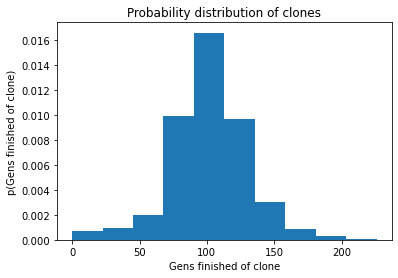

In [37]:
fig, ax = plt.subplots(1, 1)
n, bins, patches = ax.hist(df.gen, cumulative=False, density=True)
ax.set_xlabel("Gens finished of clone")
ax.set_ylabel("p(Gens finished of clone)")
ax.set_title("Probability distribution of clones")

Text(0.5, 1.0, 'CDF')

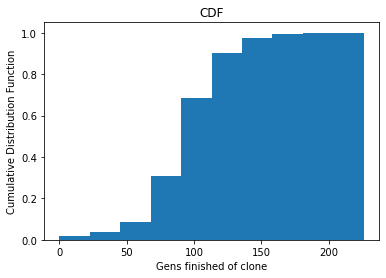

In [38]:
fig, ax = plt.subplots(1, 1)
n, bins, patches = ax.hist(df.gen, cumulative=True, density=True)
ax.set_xlabel("Gens finished of clone")
ax.set_ylabel("Cumulative Distribution Function")
ax.set_title("CDF")

## Distribution of traj lengths

In [9]:
wu_length = 10
traj_lengths_ns = df['gen'].values*wu_length

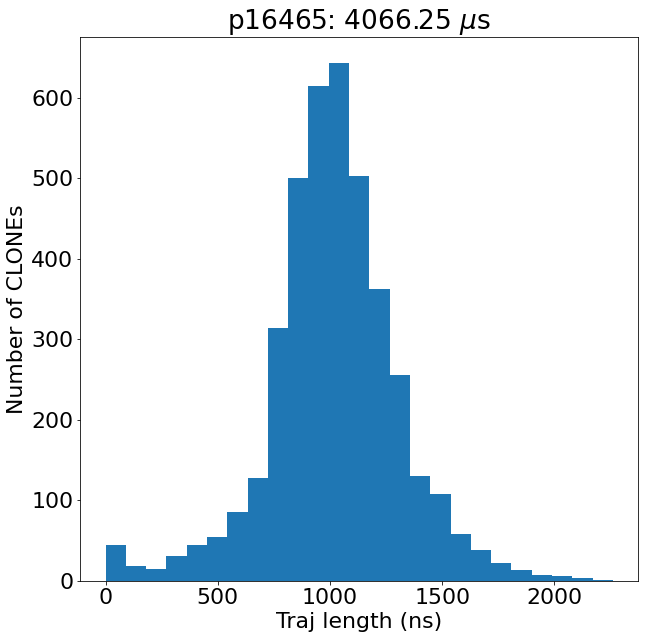

In [32]:
plt.figure(figsize=(10,10))
plt.hist(traj_lengths_ns, range=(0, traj_lengths_ns.max()), bins=25)
plt.xlabel("Traj length (ns)")
plt.ylabel("Number of CLONEs")
plt.title(f"p{project_number}: "+str(traj_lengths_ns.sum()/1000)+ " $\mu$s")
plt.savefig("p16465-traj-distribution.png", dpi=300)